# Simulation

Here we generate a simulated set of features, `Xs`, with the corresponding 'brain' response `Y`

If you have torch installed with a NVIDIA GPU with cuda enabled, you will be able to run things a lot more quickly (though here we use a low sample size and it won't matter much)

In [19]:
from himalaya.backend import set_backend

set_backend('torch', on_error='warn')

<module 'himalaya.backend.torch' from '/home/leo/git/compare_variance_residual/.venv/lib/python3.13/site-packages/himalaya/backend/torch.py'>

In [20]:
from compare_variance_residual.simulation.dataset import generate_dataset

Xs, Y = generate_dataset(d_list=[10, 10, 10], n_samples=1000)

note that the size of each feature X corresponds to summing up d_list times two, due to the way the hidden correlations between features are constructed (at least with the way the feature spaces are made to be orthogonal)

In [21]:
Xs[0].shape

torch.Size([1000, 60])

now we can use the residual method and variance partitioning to deduce how much each variance each feature explains uniquely

In [22]:
n_samples_train = 900  # here we use 90 samples as training, and the remaining 10 as test samples

In [23]:
from compare_variance_residual.simulation.residual_method import residual_method
from compare_variance_residual.simulation.variance_partitioning import variance_partitioning

residual_method_results = residual_method(Xs, Y, n_samples_train)
variance_partitioning_results = variance_partitioning(Xs, Y, n_samples_train)

These results contain a bit more information, which we will not use here (mostly used for sanity checks)

In [24]:
_, _, rm_pred_x0, rm_pred_x1 = residual_method_results
_, _, _, _, vp_pred_x0, vp_pred_x1 = variance_partitioning_results

Now we can plot the predicted unique contributions for feature space 0 and 1

<Axes: xlabel='Feature Space', ylabel='Result'>

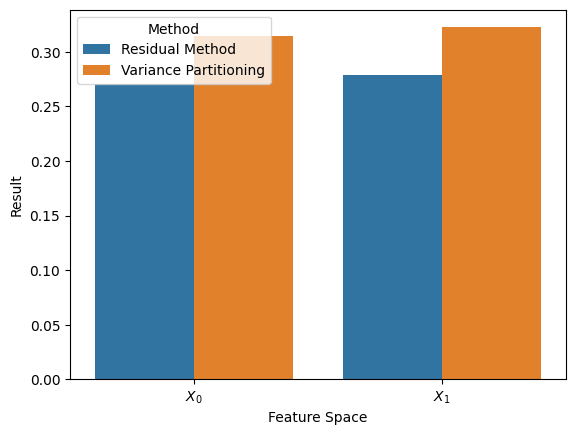

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    "Feature Space": [r"$X_0$", r"$X_1$", r"$X_0$", r"$X_1$"],
    "Method": ["Residual Method", "Residual Method", "Variance Partitioning", "Variance Partitioning"],
    "Result": [rm_pred_x0.mean(), rm_pred_x1.mean(), vp_pred_x0.mean(), vp_pred_x1.mean()],
})

sns.barplot(data = data, x="Feature Space", y="Result", hue="Method")

# FMRI

Here we will apply variance partitioning and the residual method to the actual brain data of subject 7. For this you will need at least

- The [features_trn_NEW.hdf](https://gin.g-node.org/denizenslab/narratives_reading_listening_fmri/src/master/features/features_trn_NEW.hdf) and [features_val_NEW.hdf](https://gin.g-node.org/denizenslab/narratives_reading_listening_fmri/src/master/features/features_val_NEW.hdf) files
- The subject's [mapper](https://gin.g-node.org/denizenslab/narratives_reading_listening_fmri/src/master/mappers/subject07_mappers.hdf) file
- The subject's brain response during reading for [training](https://gin.g-node.org/denizenslab/narratives_reading_listening_fmri/src/master/responses/subject07_reading_fmri_data_trn.hdf) and [testing](https://gin.g-node.org/denizenslab/narratives_reading_listening_fmri/src/master/responses/subject07_reading_fmri_data_val.hdf)

arranged as described in the [readme](../Readme.md).

In [2]:
subject = 7
modality = "reading"
data_dir = "../data"

We implicitly analyze the impact of low level features on the semantic feature, which is why we only have to declare that here.

In [ ]:
low_level_feature = "letters"

Now to apply the methods lets load the features and brain data. These methods only store the results in a csv file (not very intuitive but it was very practical at the time) in a folder called results in the current working directory.

In [ ]:
from compare_variance_residual.fmri.residual_method import residual_method
from compare_variance_residual.fmri.variance_partitioning import variance_partitioning

residual_method(data_dir, subject, modality, low_level_feature)
variance_partitioning(data_dir, subject, modality, low_level_feature)

Now we can load those results and display them.

In [3]:
import os
from compare_variance_residual.fmri.results import get_result_path

mapper_file = os.path.join(data_dir, "mappers", f"subject{subject:02}_mappers.hdf")
result_path = get_result_path(modality, subject)

In [ ]:
from voxelwise_tutorials.viz import plot_flatmap_from_mapper
import pandas as pd

residual_method_results = pd.read_csv(os.path.join(result_path, f"residual_{low_level_feature}_english1000_scores.csv"))
variance_partitioning_results = pd.read_csv(os.path.join(result_path, f"vp_english1000_{low_level_feature}_scores.csv"))

In [ ]:
plot_flatmap_from_mapper(residual_method_results, mapper_file)

In [ ]:
plot_flatmap_from_mapper(variance_partitioning_results, mapper_file)